# 2. clasificador del tipo de contenido basados en el titulo

In [2]:
import pandas as pd
import numpy as np
import math
import re
import unicodedata
from collections import defaultdict
from collections import Counter
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brahi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
df = pd.read_csv("./data/train.csv") 
df['titulo'] = df['titulo'].astype(str).str.lower()
df['titulo'] = df['titulo'].apply(lambda x: ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn'))

In [57]:
df['categoria'] = df['categoria'].replace({
    'entretenimiento': 'Entretenimiento',
    'deportes': 'Deportes',
    'película y animación': 'Película y Animación',
    'educación': 'Educación',
    'gente y blogs': 'Otros'
})
df['categoria'] = df['categoria'].fillna('Otros')


In [72]:
vocabulario = set()
conteoPorTitulo = []

for titulo in df['titulo']:
    palabras = re.findall(r'\b\w+\b', titulo)
    conteo = defaultdict(int)
    for palabra in palabras:
        vocabulario.add(palabra)
        conteo[palabra] += 1
    conteoPorTitulo.append(conteo)

vocabulario = sorted(vocabulario) 
matrizConteo = []
for conteo in conteoPorTitulo:
    fila = [conteo.get(p, 0) for p in vocabulario]
    matrizConteo.append(fila)

dfMatriz = pd.DataFrame(matrizConteo, columns=vocabulario)
print("Palabras unicas en el dataset:", len(vocabulario))

Palabras unicas en el dataset: 1816


In [74]:
stop_words = set(stopwords.words('spanish')).union(ENGLISH_STOP_WORDS)
palabrasValidas = [p for p in vocabulario if p not in stop_words]

tfMatriz = []

for conteo in conteoPorTitulo:
    total = sum(conteo[p] for p in palabrasValidas)
    tf_row = [conteo.get(p, 0) / total if total > 0 else 0 for p in palabrasValidas]
    tfMatriz.append(tf_row)

tf_df = pd.DataFrame(tfMatriz, columns=palabrasValidas)
df_conteo_full = pd.DataFrame(matrizConteo, columns=vocabulario)
conteo_preview = df_conteo_full.head()
df_tf = pd.DataFrame(tfMatriz, columns=palabrasValidas)
tf_preview = df_tf.head()

In [62]:
X_tfidf = np.array(tfMatriz) * idfArray
le = LabelEncoder()
y = le.fit_transform(df['categoria'])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [63]:
numDocs = len(df)
idfVector = [
    math.log((numDocs + 1) / (1 + sum(1 for c in conteoPorTitulo if p in c)))
    for p in palabrasValidas
]
idfArray = np.array(idfVector)

In [64]:
n_docs = len(df)
idfVector = [
    math.log((n_docs + 1) / (1 + sum(1 for conteo in conteoPorTitulo if p in conteo)))
    for p in palabrasValidas
]
idf_array = np.array(idfVector)
display(.head())

In [65]:
X_tfidf = np.array(tfMatriz) * idfArray
df['categoria'] = df['categoria'].replace({
    'entretenimiento': 'Entretenimiento',
    'deportes': 'Deportes',
    'película y animación': 'Película y Animación',
    'educación': 'Educación'
})
df['categoria'] = df['categoria'].fillna('Otros')

le = LabelEncoder()
y = le.fit_transform(df['categoria'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [104]:
logModel = LogisticRegression(max_iter=1000)
logModel.fit(X_train, y_train)
y_pred_log = logModel.predict(X_test)
print(classification_report(y_test, y_pred_log, target_names=le.classes_))


                      precision    recall  f1-score   support

            Deportes       0.89      0.84      0.86        38
           Educación       0.54      0.29      0.38        24
     Entretenimiento       0.61      0.77      0.68        48
       Gente y Blogs       0.50      0.25      0.33         8
               Otros       0.80      0.40      0.53        10
Película y Animación       0.49      0.62      0.55        32

            accuracy                           0.64       160
           macro avg       0.64      0.53      0.56       160
        weighted avg       0.65      0.64      0.63       160



In [105]:
rfModel = RandomForestClassifier(n_estimators=100)
rfModel.fit(X_train, y_train)
y_pred_rf = rfModel.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


                      precision    recall  f1-score   support

            Deportes       0.90      0.74      0.81        38
           Educación       0.67      0.33      0.44        24
     Entretenimiento       0.64      0.77      0.70        48
       Gente y Blogs       0.67      0.25      0.36         8
               Otros       0.71      0.50      0.59        10
Película y Animación       0.47      0.72      0.57        32

            accuracy                           0.64       160
           macro avg       0.68      0.55      0.58       160
        weighted avg       0.68      0.64      0.64       160



In [107]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['titulo'])
sequences = tokenizer.texts_to_sequences(df['titulo'])
padded = pad_sequences(sequences, padding='post', maxlen=30)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(padded, y, test_size=0.2, random_state=42)

ModeloLSTM = Sequential([
    Embedding(input_dim=5000, output_dim=64), 
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(len(le.classes_), activation='softmax')
])

ModeloLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ModeloLSTM.fit(X_train_lstm, y_train_lstm, epochs=15, validation_split=0.1)
y_proba_lstm = ModeloLSTM.predict(X_test_lstm)

# Convertir a clases predichas
y_pred_lstm = y_proba_lstm.argmax(axis=1)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.2580 - loss: 1.7468 - val_accuracy: 0.2656 - val_loss: 1.7442
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2497 - loss: 1.6559 - val_accuracy: 0.2656 - val_loss: 1.7295
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2599 - loss: 1.6614 - val_accuracy: 0.2656 - val_loss: 1.7189
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.2346 - loss: 1.6711 - val_accuracy: 0.2656 - val_loss: 1.7442
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2915 - loss: 1.6380 - val_accuracy: 0.2969 - val_loss: 1.7178
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3497 - loss: 1.5722 - val_accuracy: 0.4844 - val_loss: 1.6906
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4756 - loss: 1.3482 - val_accuracy: 0.5000 - val_loss: 1.5805
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4778 - loss: 1.3687 - val_accuracy: 0.3594 - 

In [108]:
lstm_eval = ModeloLSTM.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Accuracy: {lstm_eval[1]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4316 - loss: 1.6036
LSTM Accuracy: 0.45625001192092896


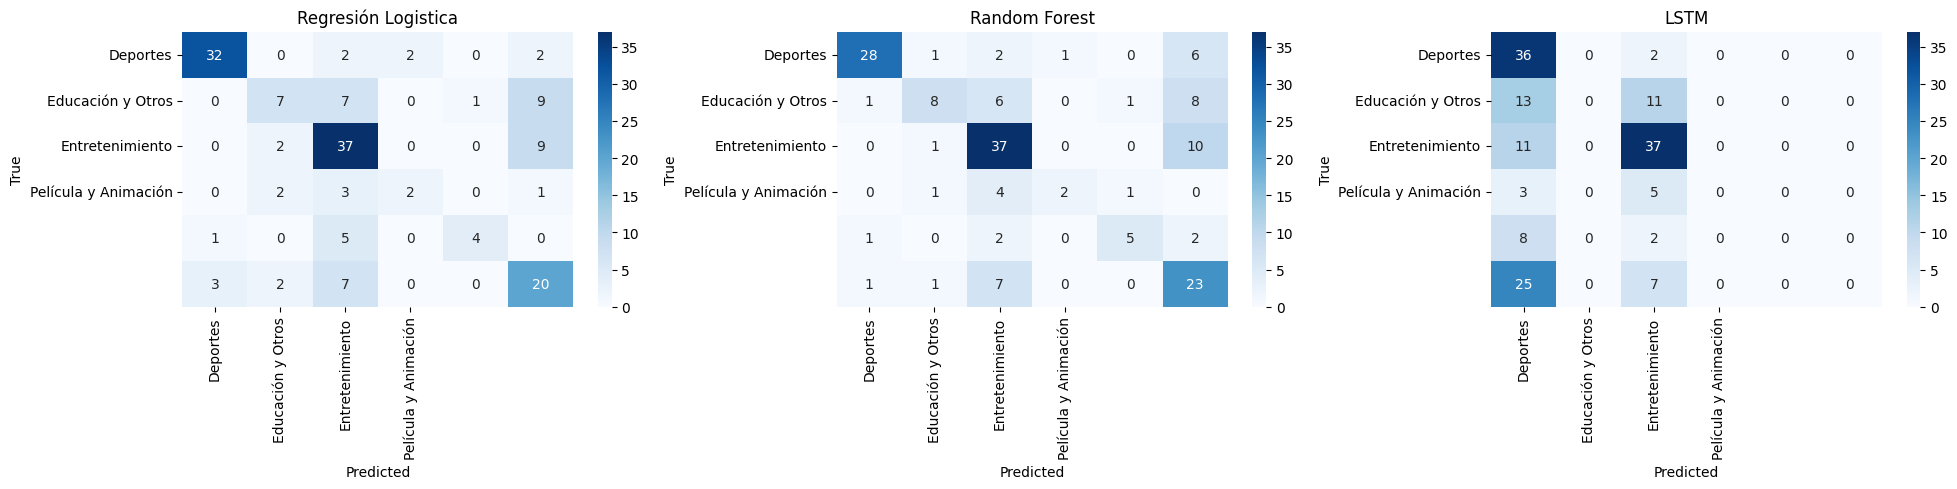

In [109]:
lass_names = ["Deportes", "Educación y Otros", "Entretenimiento", "Película y Animación"]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

nombreModelo = ['Regresión Logistica', 'Random Forest', 'LSTM']
predictions = [y_pred_log, y_pred_rf, y_pred_lstm]

for i, (pred, name) in enumerate(zip(predictions, nombreModelo)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
                yticklabels=class_names, ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()

In [83]:
df_conteo_full = pd.DataFrame(matrizConteo, columns=vocabulario)
df_tf = pd.DataFrame(tfMatriz, columns=palabrasValidas)
n_docs = len(df)
idf_vector = [
    math.log((n_docs + 1) / (1 + sum(1 for conteo in conteoPorTitulo if p in conteo)))
    for p in palabrasValidas
]
idf_array = np.array(idf_vector)
tfidf_matrix = np.array(tfMatriz) * idf_array
df_tfidf = pd.DataFrame(tfidf_matrix, columns=palabrasValidas)

display(df_tf.head())

display(df_conteo_full.head())

display(df_tfidf.head())

,00,01,02,03,04,05,06,07,08,09,...,yaneth,youtube,yowamushi,ysabel,ysue,yudi,z,zardo,zombie,zootecnia
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,00,01,02,03,04,05,06,07,08,09,...,yo,youtube,yowamushi,ysabel,ysue,yudi,z,zardo,zombie,zootecnia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,00,01,02,03,04,05,06,07,08,09,...,yaneth,youtube,yowamushi,ysabel,ysue,yudi,z,zardo,zombie,zootecnia
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
def extraerMetricas(y_true, y_pred, nombre_modelo):
    reporte = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        "Modelo": nombre_modelo,
        "Accuracy": reporte["accuracy"],
        "Precision promedio": reporte["macro avg"]["precision"],
        "Recall promedio": reporte["macro avg"]["recall"],
        "F1-score promedio": reporte["macro avg"]["f1-score"]
    }
metricasLog = extraerMetricas(y_test, y_pred_log, "Regresión Logística")
metricasRf = extraerMetricas(y_test, y_pred_rf, "Random Forest")
metricasLSTM = extraerMetricas(y_test, y_pred_lstm, "LSTM")

comparacion_metricas = pd.DataFrame([metricasLog, metricasRf, metricasLSTM])
print(comparacion_metricas)

                Modelo  Accuracy  Precision promedio  Recall promedio  \
0  Regresión Logística   0.63750            0.636952         0.529934   
1        Random Forest   0.64375            0.676361         0.551626   
2                 LSTM   0.45625            0.158854         0.286367   

   F1-score promedio  
0           0.556126  
1           0.578987  
2           0.199671  


In [113]:
df_test = pd.read_csv("./data/test.csv")
df_test['titulo'] = df_test['titulo'].astype(str).str.lower()
df_test['titulo'] = df_test['titulo'].apply(
    lambda x: ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn')
)

In [114]:
from collections import defaultdict
tf_test_matrix = []

for titulo in df_test['titulo']:
    palabras = re.findall(r'\b\w+\b', titulo)
    conteo = Counter([p for p in palabras if p in palabras_validas])
    total = sum(conteo.values())
    tf_row = [conteo.get(p, 0)/total if total > 0 else 0 for p in palabras_validas]
    tf_test_matrix.append(tf_row)

X_test_k = np.array(tf_test_matrix) * idf_array
predLogK = le.inverse_transform(log_model.predict(X_test_k))
predRfK = le.inverse_transform(rf_model.predict(X_test_k))
test_sequences = tokenizer.texts_to_sequences(df_test['titulo'])
X_testLSTMK = pad_sequences(test_sequences, padding='post', maxlen=30)
predLSTMK = model_lstm.predict(X_testLSTMK).argmax(axis=1)
predLSTMK = le.inverse_transform(predLSTMK)
df_log_output = pd.DataFrame({
    'ID': df_test['index'],
    'categoria': predLogK
})
df_log_output.to_csv("prediccionesLogistica.csv", index=False)

df_rf_output = pd.DataFrame({
    'ID': df_test['index'],
    'categoria': predRfK
})
df_rf_output.to_csv("prediccionesRandomforest.csv", index=False)

df_lstm_output = pd.DataFrame({
    'ID': df_test['index'],
    'categoria': predLSTMK
})
df_lstm_output.to_csv("prediccionesLstm.csv", index=False)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
